In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.datasets as dset
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np

In [8]:
dataroot = "data"

image_size = 64
batch_size = 128

# Size of z latent vector (i.e. size of generator input)
latent_size = 100

lr = 3e-4
z_dim = 64
image_dim = image_size * image_size * 1  # 784
batch_size = 32
num_epochs = 50

In [24]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [25]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

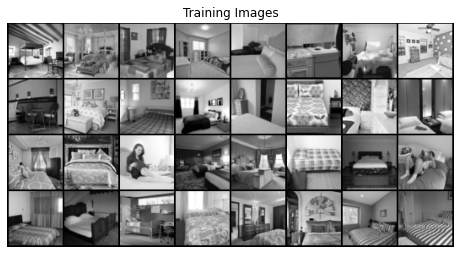

In [26]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [57]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.02),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.02),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.02),
            nn.Linear(1024, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [58]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.LeakyReLU(0.02),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.02),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.02),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [59]:
disc = Discriminator(image_size*image_size).to(device)
gen = Generator(z_dim, image_size*image_size).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [60]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

step = 0

In [61]:
device

device(type='cuda', index=0)

In [62]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.view(-1, image_size*image_size).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        D_x = disc_fake.mean().item()
        opt_disc.step()
        

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        D_G_z1 = output.mean().item()
        
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        D_G_z2 = output.mean().item()
        
        opt_gen.step()
        
        
        
         # Output training stats
        if batch_idx % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, batch_idx, len(dataloader),
                     lossD.item(), lossG.item()))
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, image_size, image_size).detach().cpu()
                #fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        iters += 1

[0/50][0/9473]	Loss_D: 0.6958	Loss_G: 0.7263
[0/50][100/9473]	Loss_D: 0.8357	Loss_G: 0.2922
[0/50][200/9473]	Loss_D: 0.2112	Loss_G: 1.6043
[0/50][300/9473]	Loss_D: 0.0189	Loss_G: 5.6214
[0/50][400/9473]	Loss_D: 1.2425	Loss_G: 0.6388
[0/50][500/9473]	Loss_D: 0.2538	Loss_G: 2.4934
[0/50][600/9473]	Loss_D: 0.3874	Loss_G: 0.8540
[0/50][700/9473]	Loss_D: 0.3226	Loss_G: 1.4603
[0/50][800/9473]	Loss_D: 0.5825	Loss_G: 1.0599
[0/50][900/9473]	Loss_D: 0.0705	Loss_G: 2.4459
[0/50][1000/9473]	Loss_D: 0.1331	Loss_G: 1.8395
[0/50][1100/9473]	Loss_D: 0.4990	Loss_G: 0.6135
[0/50][1200/9473]	Loss_D: 0.0389	Loss_G: 3.3964
[0/50][1300/9473]	Loss_D: 0.2454	Loss_G: 3.7168
[0/50][1400/9473]	Loss_D: 1.0495	Loss_G: 4.9364
[0/50][1500/9473]	Loss_D: 0.3047	Loss_G: 1.0037
[0/50][1600/9473]	Loss_D: 0.1057	Loss_G: 2.6897
[0/50][1700/9473]	Loss_D: 0.3884	Loss_G: 2.4024
[0/50][1800/9473]	Loss_D: 0.4133	Loss_G: 2.1248
[0/50][1900/9473]	Loss_D: 0.4236	Loss_G: 1.5451
[0/50][2000/9473]	Loss_D: 0.1722	Loss_G: 1.7721
[0/5

[1/50][7700/9473]	Loss_D: 0.4374	Loss_G: 1.2528
[1/50][7800/9473]	Loss_D: 0.5779	Loss_G: 1.2999
[1/50][7900/9473]	Loss_D: 0.4667	Loss_G: 2.2097
[1/50][8000/9473]	Loss_D: 0.5410	Loss_G: 1.3153
[1/50][8100/9473]	Loss_D: 0.5249	Loss_G: 1.4099
[1/50][8200/9473]	Loss_D: 0.4825	Loss_G: 1.0334
[1/50][8300/9473]	Loss_D: 0.4892	Loss_G: 1.4664
[1/50][8400/9473]	Loss_D: 0.3340	Loss_G: 1.4856
[1/50][8500/9473]	Loss_D: 0.6795	Loss_G: 0.9629
[1/50][8600/9473]	Loss_D: 0.5198	Loss_G: 1.3362
[1/50][8700/9473]	Loss_D: 0.5090	Loss_G: 1.2684
[1/50][8800/9473]	Loss_D: 0.4718	Loss_G: 1.4665
[1/50][8900/9473]	Loss_D: 0.4454	Loss_G: 1.3545
[1/50][9000/9473]	Loss_D: 0.5156	Loss_G: 1.1924
[1/50][9100/9473]	Loss_D: 0.4889	Loss_G: 1.3813
[1/50][9200/9473]	Loss_D: 0.5940	Loss_G: 1.0270
[1/50][9300/9473]	Loss_D: 0.5334	Loss_G: 1.1990
[1/50][9400/9473]	Loss_D: 0.5051	Loss_G: 1.3080
[2/50][0/9473]	Loss_D: 0.5633	Loss_G: 1.4748
[2/50][100/9473]	Loss_D: 0.4937	Loss_G: 1.1619
[2/50][200/9473]	Loss_D: 0.4545	Loss_G: 1.57

[3/50][5900/9473]	Loss_D: 0.5685	Loss_G: 1.1607
[3/50][6000/9473]	Loss_D: 0.6675	Loss_G: 0.9016
[3/50][6100/9473]	Loss_D: 0.6193	Loss_G: 0.8980
[3/50][6200/9473]	Loss_D: 0.6877	Loss_G: 0.9555
[3/50][6300/9473]	Loss_D: 0.6407	Loss_G: 0.8868
[3/50][6400/9473]	Loss_D: 0.5919	Loss_G: 0.9416
[3/50][6500/9473]	Loss_D: 0.5486	Loss_G: 1.1150
[3/50][6600/9473]	Loss_D: 0.5270	Loss_G: 1.1270
[3/50][6700/9473]	Loss_D: 0.7311	Loss_G: 0.7306
[3/50][6800/9473]	Loss_D: 0.6314	Loss_G: 0.9596
[3/50][6900/9473]	Loss_D: 0.6296	Loss_G: 1.0241
[3/50][7000/9473]	Loss_D: 0.7079	Loss_G: 0.7911
[3/50][7100/9473]	Loss_D: 0.6173	Loss_G: 0.8363
[3/50][7200/9473]	Loss_D: 0.6470	Loss_G: 0.8913
[3/50][7300/9473]	Loss_D: 0.5818	Loss_G: 0.9235
[3/50][7400/9473]	Loss_D: 0.6008	Loss_G: 0.8536
[3/50][7500/9473]	Loss_D: 0.6632	Loss_G: 0.8647
[3/50][7600/9473]	Loss_D: 0.7522	Loss_G: 0.9086
[3/50][7700/9473]	Loss_D: 0.5410	Loss_G: 1.1809
[3/50][7800/9473]	Loss_D: 0.5939	Loss_G: 1.0283
[3/50][7900/9473]	Loss_D: 0.6972	Loss_G:

[5/50][4100/9473]	Loss_D: 0.6309	Loss_G: 0.9801
[5/50][4200/9473]	Loss_D: 0.6171	Loss_G: 0.9223
[5/50][4300/9473]	Loss_D: 0.6282	Loss_G: 0.8968
[5/50][4400/9473]	Loss_D: 0.6735	Loss_G: 0.7665
[5/50][4500/9473]	Loss_D: 0.7066	Loss_G: 0.7652
[5/50][4600/9473]	Loss_D: 0.6786	Loss_G: 0.7209
[5/50][4700/9473]	Loss_D: 0.7051	Loss_G: 0.7400
[5/50][4800/9473]	Loss_D: 0.7228	Loss_G: 0.7727
[5/50][4900/9473]	Loss_D: 0.7021	Loss_G: 0.7837
[5/50][5000/9473]	Loss_D: 0.7388	Loss_G: 0.7170
[5/50][5100/9473]	Loss_D: 0.6612	Loss_G: 0.9351
[5/50][5200/9473]	Loss_D: 0.6537	Loss_G: 0.8829
[5/50][5300/9473]	Loss_D: 0.6492	Loss_G: 0.9163
[5/50][5400/9473]	Loss_D: 0.5965	Loss_G: 0.9469
[5/50][5500/9473]	Loss_D: 0.5980	Loss_G: 0.9273
[5/50][5600/9473]	Loss_D: 0.6110	Loss_G: 0.9213
[5/50][5700/9473]	Loss_D: 0.6174	Loss_G: 0.7250
[5/50][5800/9473]	Loss_D: 0.5995	Loss_G: 1.0643
[5/50][5900/9473]	Loss_D: 0.6012	Loss_G: 0.8979
[5/50][6000/9473]	Loss_D: 0.6709	Loss_G: 0.7948
[5/50][6100/9473]	Loss_D: 0.6552	Loss_G:

[7/50][2300/9473]	Loss_D: 0.6634	Loss_G: 0.7226
[7/50][2400/9473]	Loss_D: 0.6502	Loss_G: 0.8353
[7/50][2500/9473]	Loss_D: 0.6444	Loss_G: 0.7448
[7/50][2600/9473]	Loss_D: 0.7279	Loss_G: 0.7331
[7/50][2700/9473]	Loss_D: 0.6704	Loss_G: 0.7336
[7/50][2800/9473]	Loss_D: 0.6609	Loss_G: 0.8448
[7/50][2900/9473]	Loss_D: 0.6831	Loss_G: 0.9044
[7/50][3000/9473]	Loss_D: 0.6299	Loss_G: 1.1747
[7/50][3100/9473]	Loss_D: 0.6674	Loss_G: 0.9292
[7/50][3200/9473]	Loss_D: 0.6827	Loss_G: 0.8404
[7/50][3300/9473]	Loss_D: 0.6853	Loss_G: 0.7117
[7/50][3400/9473]	Loss_D: 0.6672	Loss_G: 0.7069
[7/50][3500/9473]	Loss_D: 0.6682	Loss_G: 0.7633
[7/50][3600/9473]	Loss_D: 0.6990	Loss_G: 0.8135
[7/50][3700/9473]	Loss_D: 0.6723	Loss_G: 0.8970
[7/50][3800/9473]	Loss_D: 0.6759	Loss_G: 0.8292
[7/50][3900/9473]	Loss_D: 0.6750	Loss_G: 0.8383
[7/50][4000/9473]	Loss_D: 0.7098	Loss_G: 0.8200
[7/50][4100/9473]	Loss_D: 0.6506	Loss_G: 0.7634
[7/50][4200/9473]	Loss_D: 0.6631	Loss_G: 0.9144
[7/50][4300/9473]	Loss_D: 0.6631	Loss_G:

[9/50][500/9473]	Loss_D: 0.6343	Loss_G: 0.7659
[9/50][600/9473]	Loss_D: 0.6945	Loss_G: 0.8367
[9/50][700/9473]	Loss_D: 0.6043	Loss_G: 0.7718
[9/50][800/9473]	Loss_D: 0.6581	Loss_G: 0.7435
[9/50][900/9473]	Loss_D: 0.6630	Loss_G: 0.7521
[9/50][1000/9473]	Loss_D: 0.6854	Loss_G: 0.7633
[9/50][1100/9473]	Loss_D: 0.7180	Loss_G: 0.7200
[9/50][1200/9473]	Loss_D: 0.7368	Loss_G: 0.7110
[9/50][1300/9473]	Loss_D: 0.6477	Loss_G: 0.8131
[9/50][1400/9473]	Loss_D: 0.6730	Loss_G: 0.7689
[9/50][1500/9473]	Loss_D: 0.6586	Loss_G: 0.7468
[9/50][1600/9473]	Loss_D: 0.6986	Loss_G: 0.7941
[9/50][1700/9473]	Loss_D: 0.6301	Loss_G: 0.9804
[9/50][1800/9473]	Loss_D: 0.6478	Loss_G: 0.8681
[9/50][1900/9473]	Loss_D: 0.6637	Loss_G: 0.7653
[9/50][2000/9473]	Loss_D: 0.5293	Loss_G: 1.0619
[9/50][2100/9473]	Loss_D: 0.6955	Loss_G: 0.7703
[9/50][2200/9473]	Loss_D: 0.6246	Loss_G: 0.8857
[9/50][2300/9473]	Loss_D: 0.6401	Loss_G: 0.7741
[9/50][2400/9473]	Loss_D: 0.6448	Loss_G: 0.7558
[9/50][2500/9473]	Loss_D: 0.6857	Loss_G: 0.80

[10/50][8000/9473]	Loss_D: 0.6833	Loss_G: 0.8385
[10/50][8100/9473]	Loss_D: 0.6937	Loss_G: 0.7745
[10/50][8200/9473]	Loss_D: 0.6748	Loss_G: 0.9034
[10/50][8300/9473]	Loss_D: 0.6217	Loss_G: 0.7386
[10/50][8400/9473]	Loss_D: 0.6831	Loss_G: 0.7232
[10/50][8500/9473]	Loss_D: 0.6666	Loss_G: 0.7300
[10/50][8600/9473]	Loss_D: 0.6751	Loss_G: 0.7596


KeyboardInterrupt: 

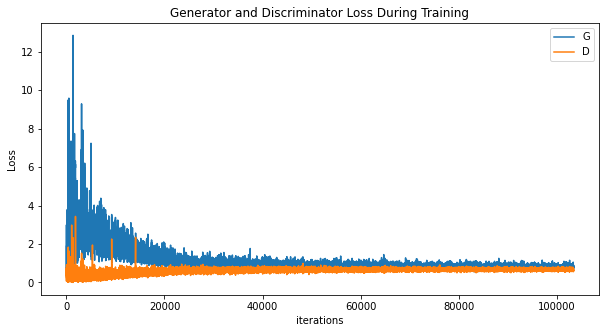

In [63]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

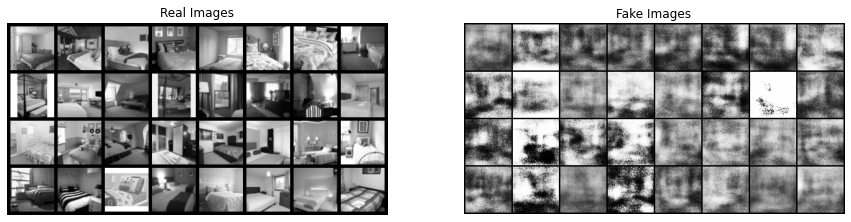

In [64]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()